In [9]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [23]:
pars = (;r = 0.04, # interest rate
    w = 2.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 2000.0) # upper bound of capital grid

(r = 0.04, w = 2.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, lb = 0.0, ub = 2000.0)

In [18]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 10, Error: 0.07614629522082848
--------------------
Iteration: 20, Error: 0.02317563934311548
--------------------
Iteration: 30, Error: 0.008543059131903213
--------------------
Iteration: 40, Error: 0.0033177378967803373
--------------------
Iteration: 50, Error: 0.001301397240633273
--------------------
Iteration: 60, Error: 0.0005074164198879686
--------------------
Iteration: 70, Error: 0.0001954412809434788
--------------------
Iteration: 80, Error: 7.422725709988425e-5
--------------------
Iteration: 90, Error: 2.7802550932166708e-5
--------------------
Iteration: 100, Error: 1.028234023144206e-5
--------------------
Iteration: 110, Error: 3.760665435328193e-6
--------------------
Iteration: 120, Error: 1.362483315775688e-6
--------------------
Iteration: 130, Error: 4.896999812879044e-7
--------------------
Converged in 133 iterations
--------------------
  1.784125 seconds (2.05 M alloca

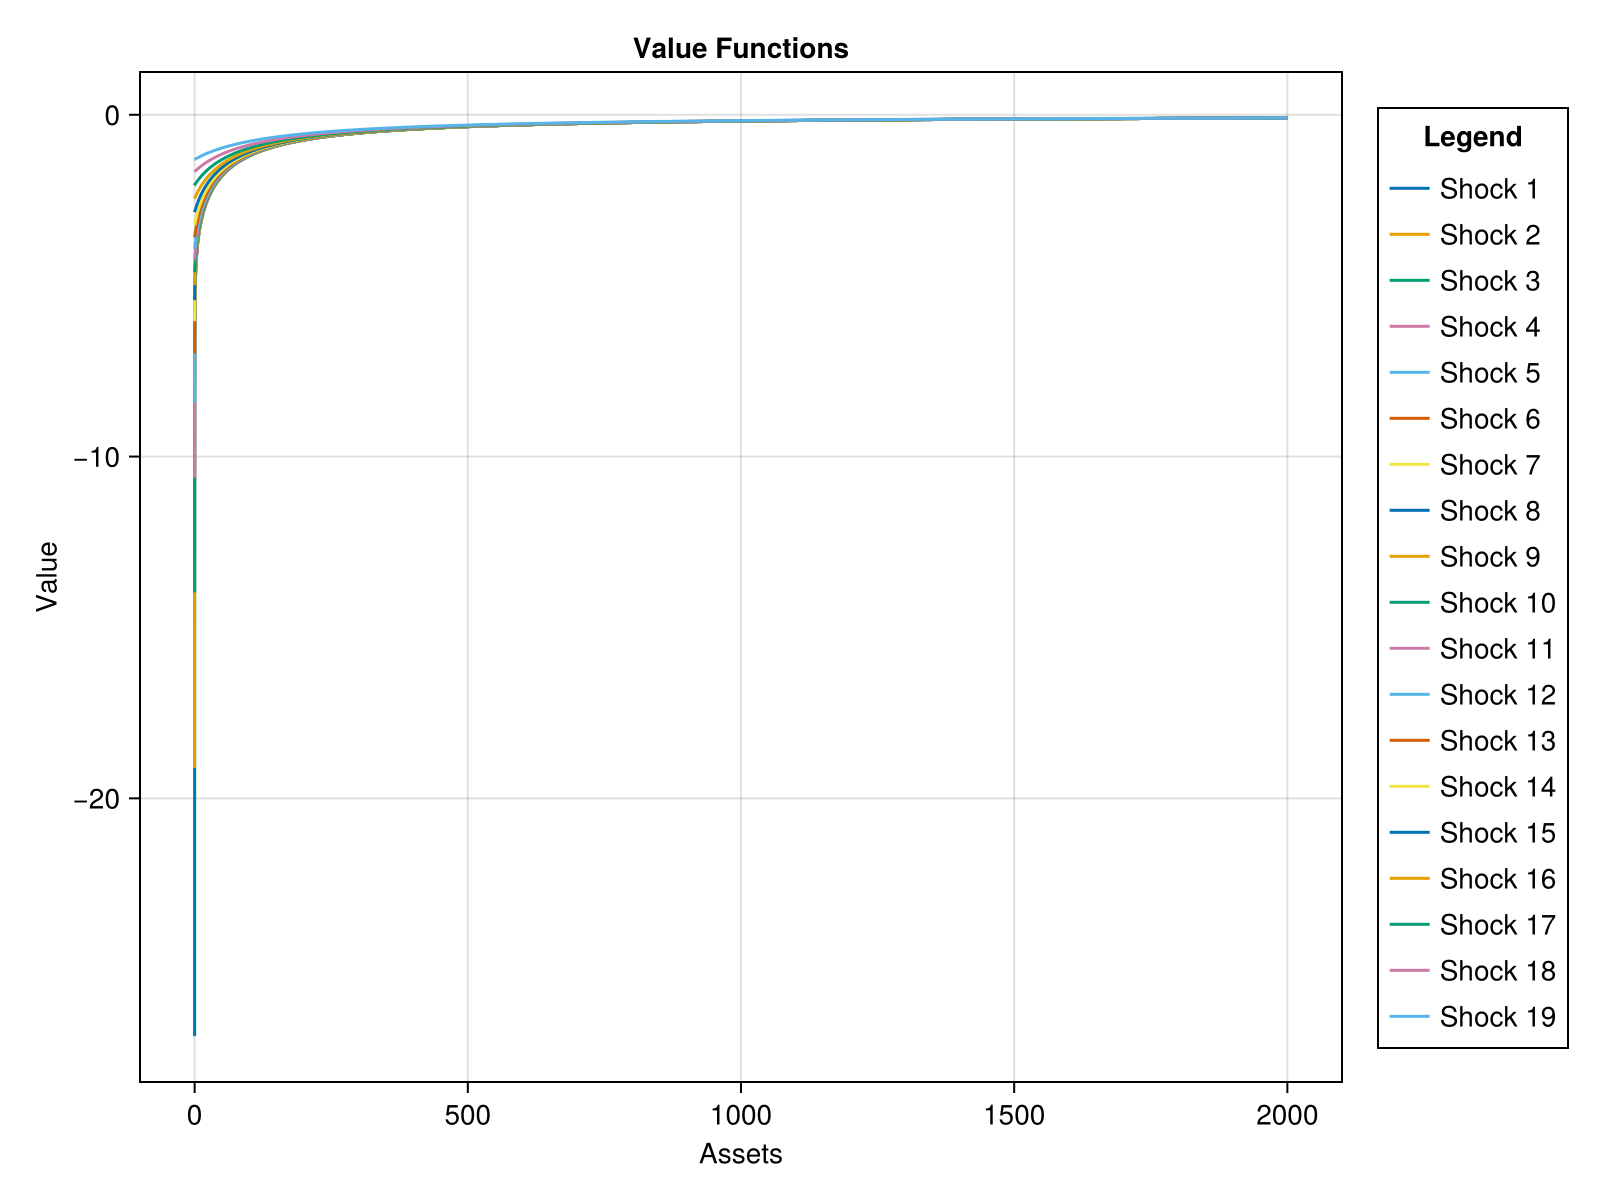

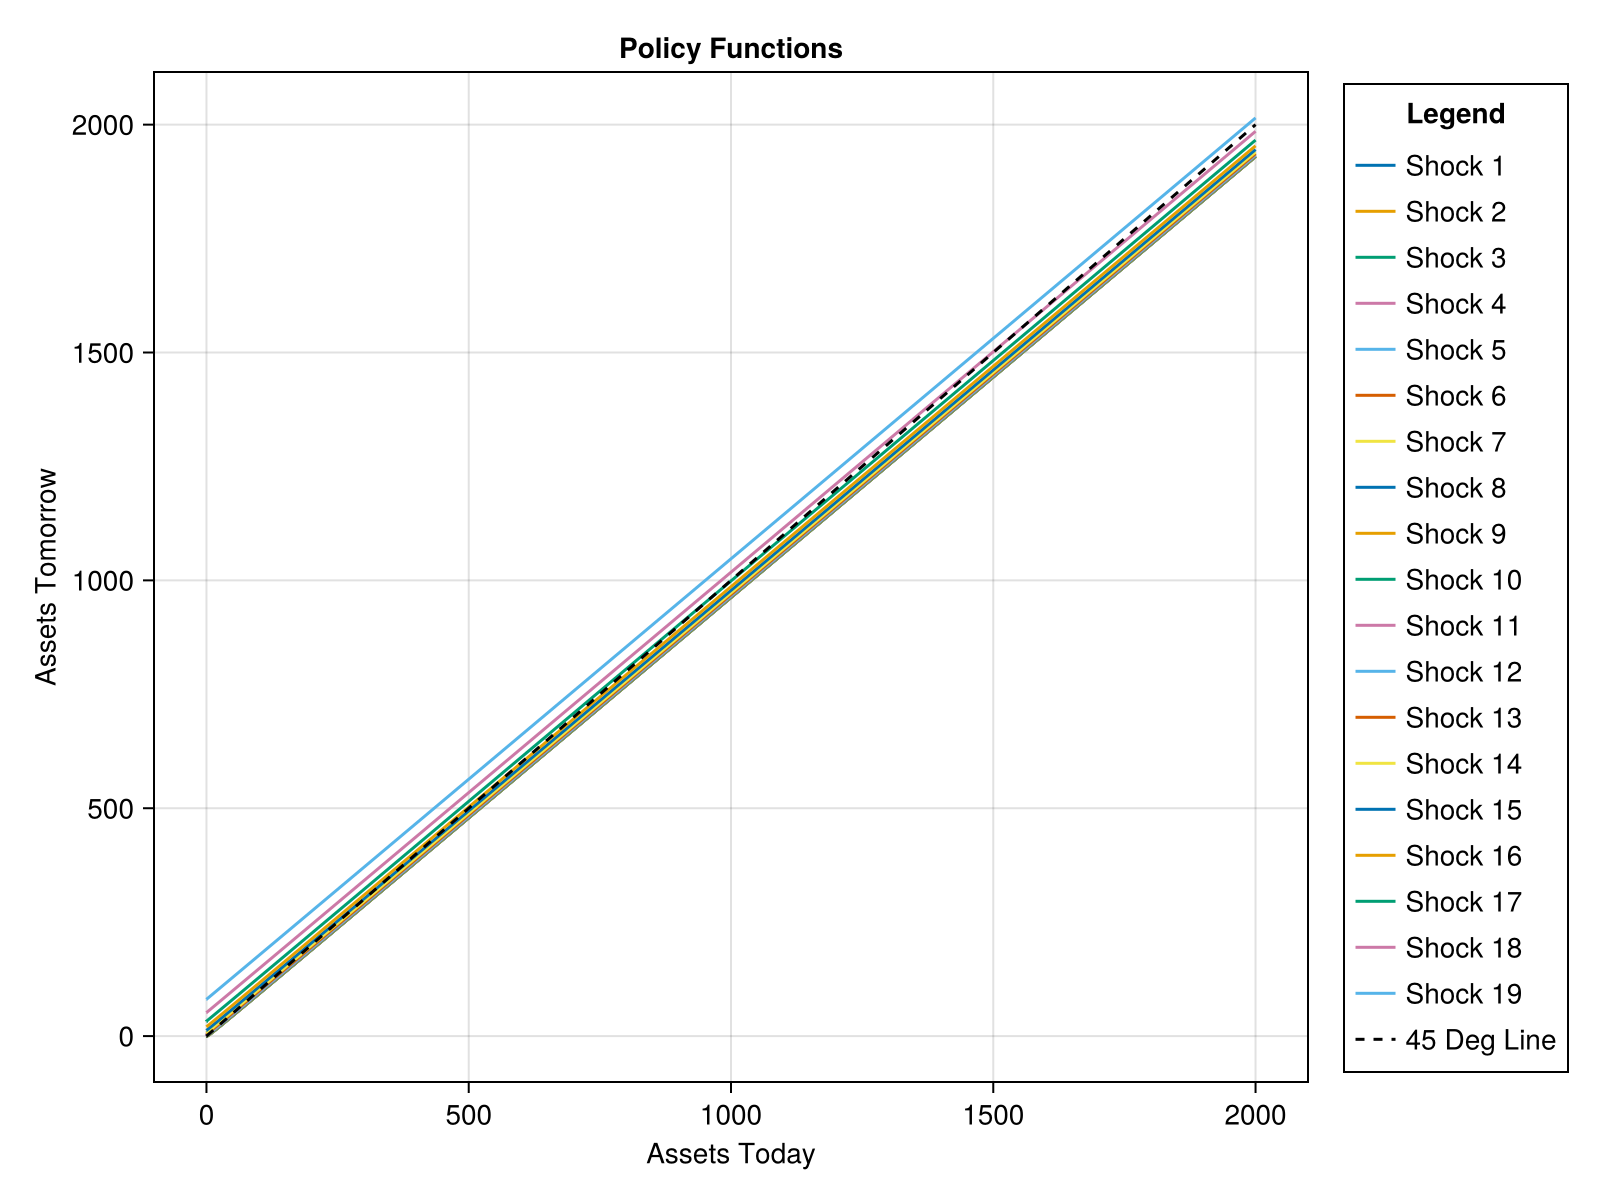

([-26.95568439437283 -19.10824747431526 … -1.666120773047043 -1.3062541536551553; -26.944974322462112 -19.10366233897033 … -1.6661204640881597 -1.3062539708755934; … ; -0.09921236502411249 -0.0992112498861022 … -0.09643273162313887 -0.09502487967664132; -0.0954365160963169 -0.09543548435686733 … -0.09286187828149779 -0.09155528134832576], [3.5281832835959455e-16 3.2221584298073533e-16 … 51.55035905829768 80.66643524941291; 3.530906479404764e-16 3.223852467219747e-16 … 51.55037818570198 80.66645446835139; … ; 1853.5870479748814 1853.608736237684 … 1909.1269147014993 1938.499033451504; 1929.8207621948272 1929.8424193676124 … 1985.3778529477354 2014.7823738040954])

In [25]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

In [20]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-p.γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.6845119800498805
--------------------
Iteration: 10, Error: 0.3105825461525695
--------------------
Iteration: 20, Error: 0.8158059569525431
--------------------
Iteration: 30, Error: 1.8182506048040636
--------------------
Iteration: 40, Error: 2.844061912443202
--------------------
Iteration: 50, Error: 2.6056798619788566
--------------------
Iteration: 60, Error: 1.4457487988640878
--------------------
Iteration: 70, Error: 0.5936878494133424
--------------------
Iteration: 80, Error: 0.2124616515636717
--------------------
Iteration: 90, Error: 0.07166211279749746
--------------------
Iteration: 100, Error: 0.023545026500983113
--------------------
Iteration: 110, Error: 0.007715712435043542
--------------------
Iteration: 120, Error: 0.002595697842309619
--------------------
Iteration: 130, Error: 0.0009105842460996882
--------------------
Iteration: 140, Error: 0.0003293906575549954
--------------------
Iteration: 150, Erro

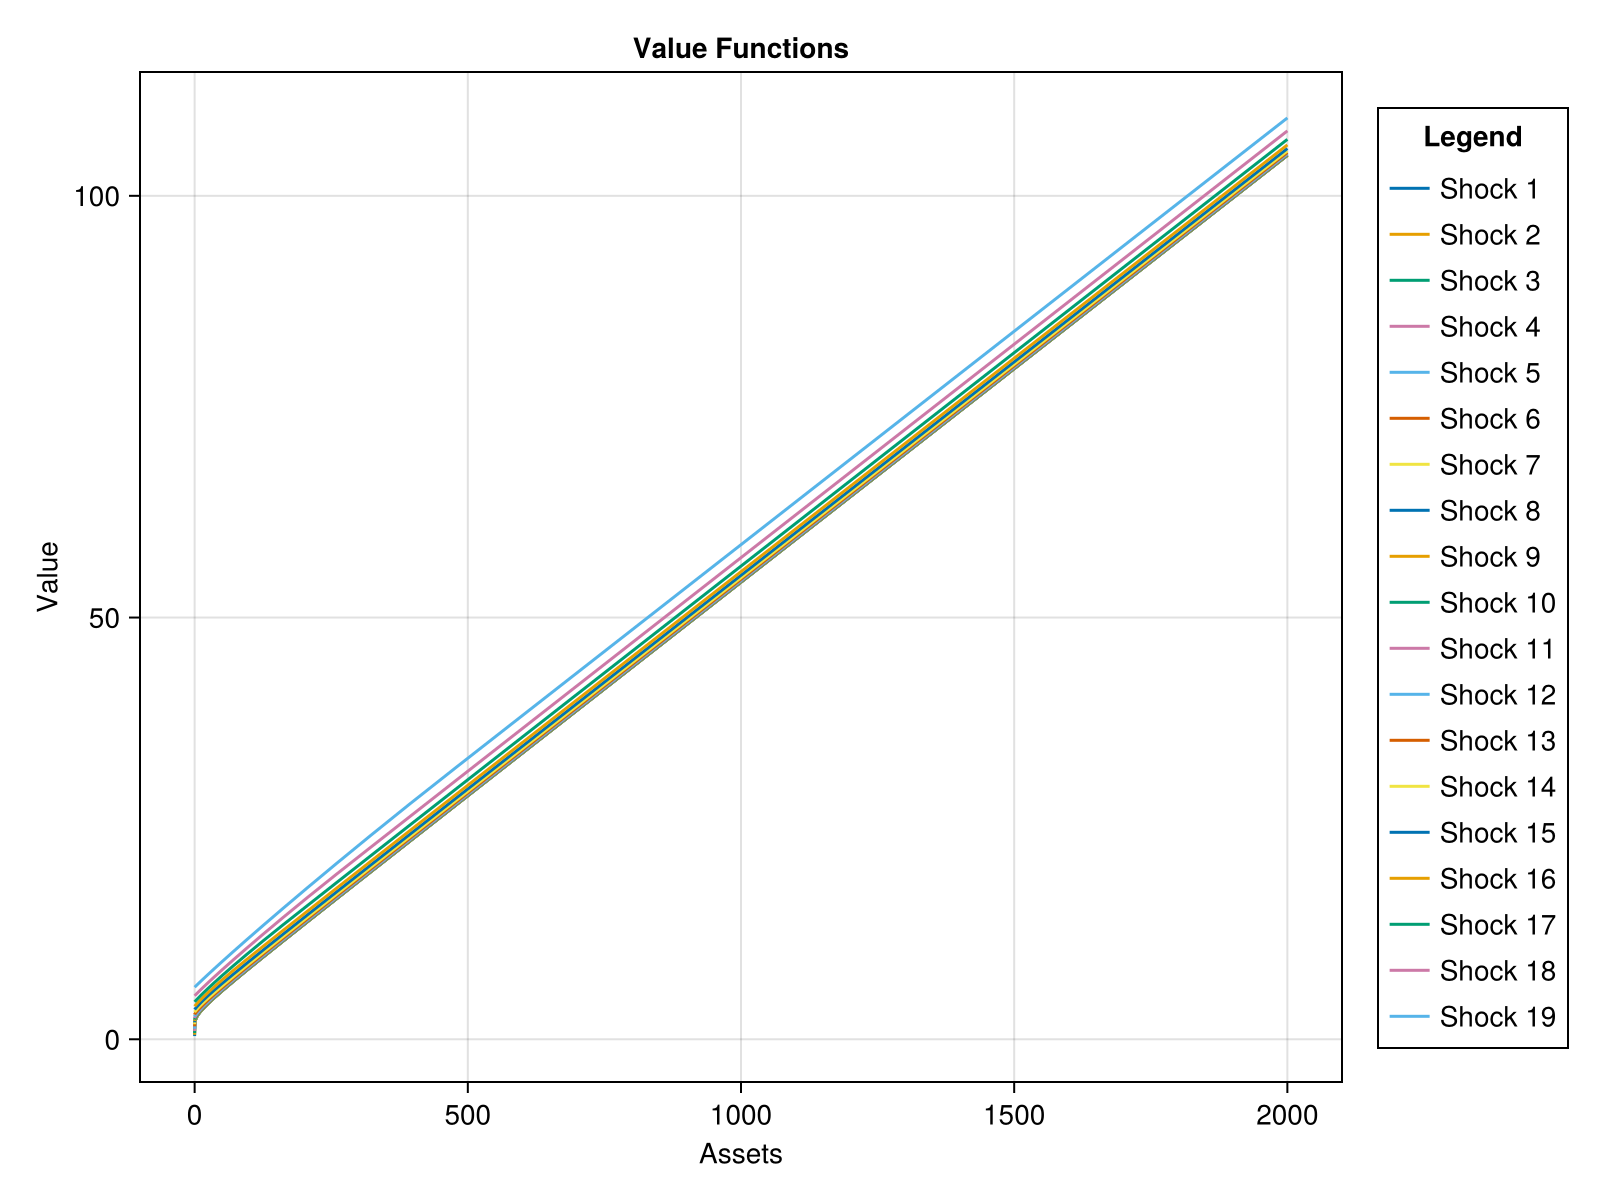

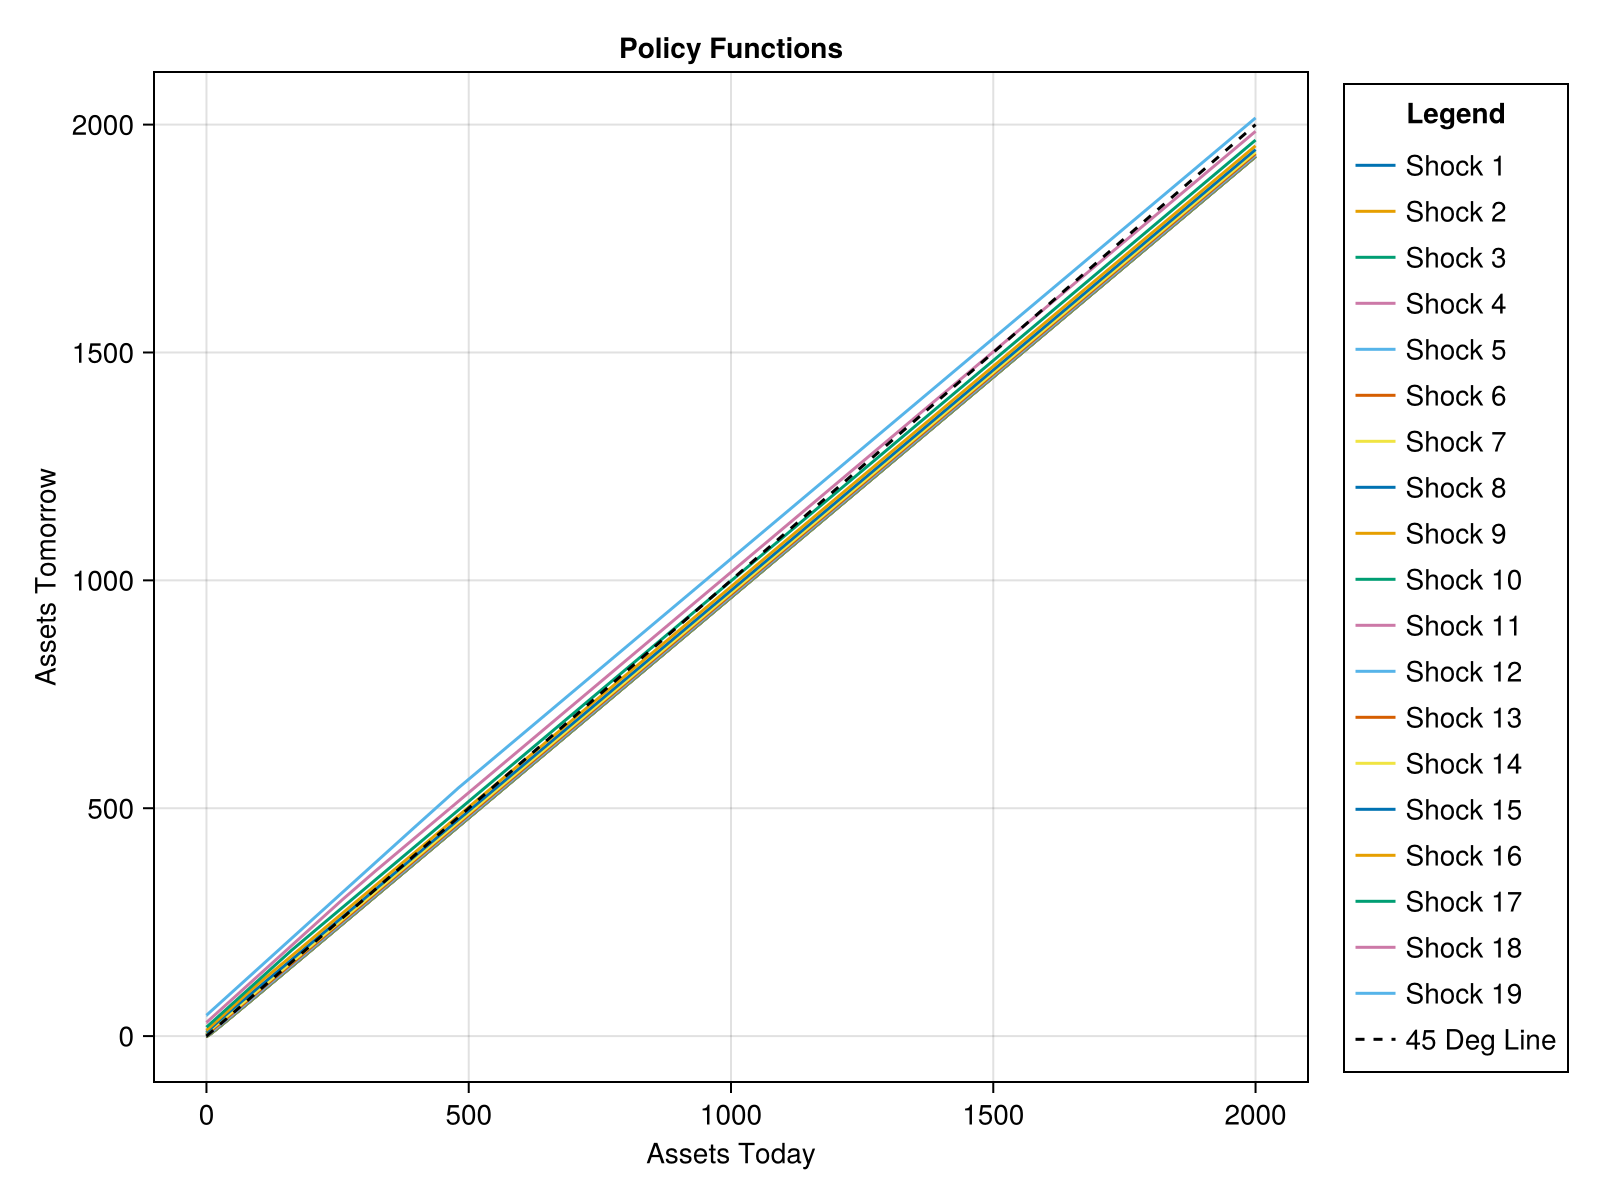

([0.3772846778607505 0.5359703764388637 … 5.155724762532013 6.173244248247633; 0.3959583176849686 0.5521108297255423 … 5.155888743560793 6.173400368457239; … ; 91.96522043636641 91.96635310191559 … 94.86995175527665 96.40611683141901; 104.79645696239525 104.79758956569097 … 107.70103771527783 109.23713051221551], [3.5181593885267114e-16 3.200489815799136e-16 … 29.877704538610402 45.667030457695695; 3.9600757145084753e-16 3.605831793078348e-16 … 29.880272439806312 45.66959835889162; … ; 1684.4165554558415 1684.4382146567623 … 1739.9622361849501 1769.3378824236927; 1929.7878709016609 1929.809530276974 … 1985.3339863930935 2014.7099016330405])

In [30]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init))
        v_init .= v_new
        if iter % 10 == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

p = (;r = 0.04, # interest rate
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    lb = 0.0, # lower bound of capital grid
    ub = 2000.0) # upper bound of capital grid

v2 = ones(p.na, p.nz)

@time begin
v_out, pol_out = vfi_CES(v2, p)
end